# Project 3: "Hello World" of Neral Networks
- Author: Ruoyu Chen
- kaggle: https://www.kaggle.com/code/ruoyuchen52119/duck-using-fast-ai

This project is to build and deploy a basic Neural Network using fast.ai, a wrapper on top of PyTorch. Based on the content of lesson 1 of the fast.ai course(https://course.fast.ai/Resources/book.html), this project will build and deploy a classification model using image data from duckduckgo(https://duckduckgo.com).

For this project, we select different transportations as our dataset and try to deploy a simple classification model using 'Resnet18'.

# 1 Download dataset
First we download random pictures of 'duck','chicken', 'turkey' and 'swan' from duckduckgo.

Download 40 images for each of  'duck','chicken', 'turkey' and 'swan' photos, and save each group of photos to a different folder. Leave the first image out of the training folder for later testing.

In [1]:
from fastbook import *

searches = 'duck','chicken', 'turkey', 'swan'
path = Path('birds')

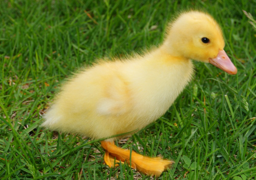

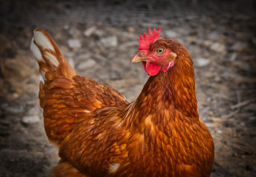

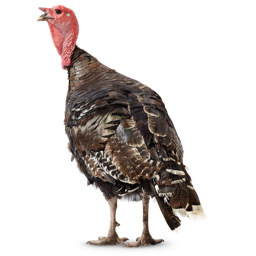

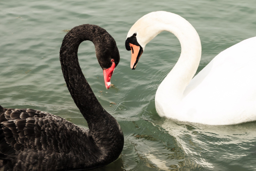

In [2]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    urls=search_images_ddg(f'{o} animal',max_images=40)

    download_url(urls[39], f'{o}.jpg', show_progress=False)
    display(Image.open(f'{o}.jpg').to_thumb(256,256))
    
    download_images(dest, urls=urls[:39])
    resize_images(path/o, max_size=300, dest=path/o)

# 2 Data Cleaning
Clear out the invalid pictures.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

# 3 Data Preparation
To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

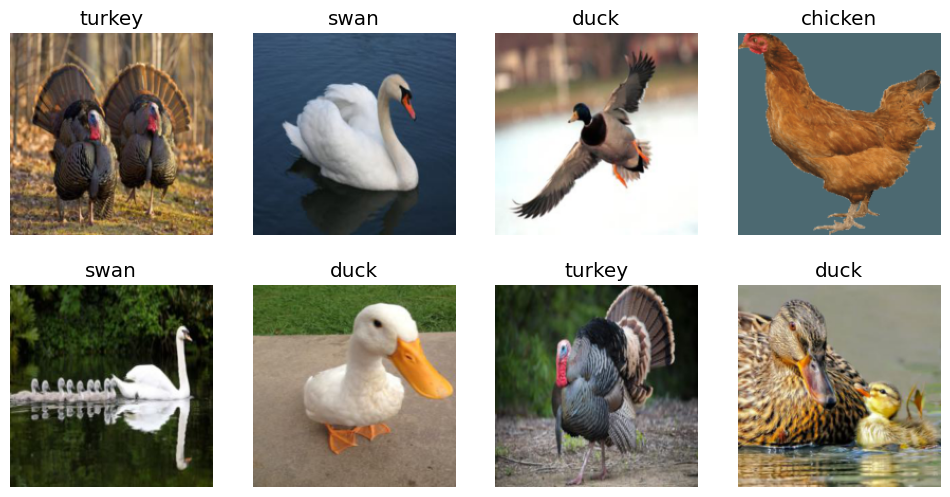

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=16)

dls.show_batch(max_n=8)

# 4 Model Training
Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that. Run it with 30 epochs and try to find the best model.

In [5]:
from fastai.vision.learner import cnn_learner
from fastai.callback.tracker import SaveModelCallback
from fastai.metrics import error_rate
from fastai.vision.models import resnet18
import torch

model_dir = Path('models')
if torch.cuda.is_available():
    defaults.device = torch.device('cuda')
    print("Using GPU")
else:
    defaults.device = torch.device('cpu')


learn = cnn_learner(dls, resnet18, metrics=error_rate, model_dir=model_dir)
save_callback = SaveModelCallback(monitor='valid_loss', fname='model')
learn.fine_tune(30, cbs=save_callback)


Using GPU


d:\conda\envs\yolox\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.295582,0.069590,0.015152,00:04


Better model found at epoch 0 with valid_loss value: 0.06959007680416107.


epoch,train_loss,valid_loss,error_rate,time
0,0.154053,0.050129,0.015152,00:03
1,0.113863,0.038610,0.000000,00:02
2,0.081533,0.028653,0.000000,00:02
3,0.054607,0.032209,0.015152,00:02
4,0.053160,0.028463,0.015152,00:03
5,0.050935,0.062601,0.030303,00:03
6,0.059112,0.106705,0.045455,00:04
7,0.067882,0.040779,0.015152,00:03
8,0.060811,0.015088,0.015152,00:03
9,0.052474,0.013905,0.000000,00:02


Better model found at epoch 0 with valid_loss value: 0.05012856423854828.
Better model found at epoch 1 with valid_loss value: 0.038610175251960754.
Better model found at epoch 2 with valid_loss value: 0.028653085231781006.
Better model found at epoch 4 with valid_loss value: 0.02846341021358967.
Better model found at epoch 8 with valid_loss value: 0.015087638981640339.
Better model found at epoch 9 with valid_loss value: 0.013905416242778301.
Better model found at epoch 11 with valid_loss value: 0.010308302007615566.



As shown in the plot, the train loss is decreasing as epoch increases; However the valid loss get to the lowest point around epoch 11. Which means after epoch 11 the model is overfitting the training set and causing performance loss.

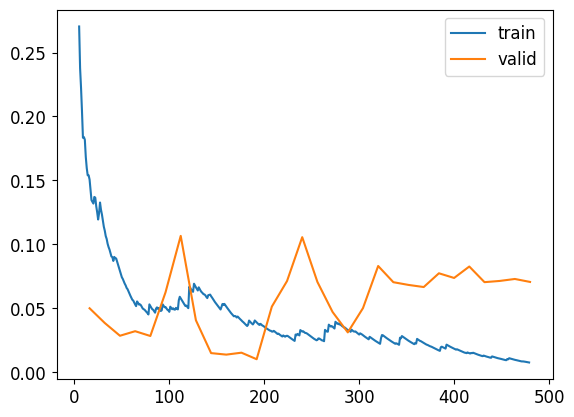

In [6]:
learn.recorder.plot_loss()

# 5 Testing

Choose the model that has the best performance.

In [7]:
learn.load('model')

d:\conda\envs\yolox\lib\site-packages\fastai\learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [8]:
import gradio as gr

def predict_image(text): 
    download_url(search_images_ddg(f'{text}',max_images=1)[0], f'{text}.jpg', show_progress=False)
    image = PILImage.create(f'{text}.jpg')
    
    prediction, _, probs = learn.predict(image)
    result = [f"This is a: {prediction}.\n-------------\n"]
    for i, prob in enumerate(probs.tolist()):
        result.append(f"Probability of class {learn.dls.vocab[i]}: {prob:.4f}\n")
    result_str = "".join(result)
    return image,result_str

# Create a Gradio interface for the model
input_interface = gr.Textbox(label="type in the picture", value = 'duck')
output_interface = [gr.Image(height=256, width=256),gr.Textbox()]

gr.Interface(fn=predict_image, inputs=input_interface, outputs=output_interface,live=True).launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Test on the 4 pictures we removed from the training set earlier.

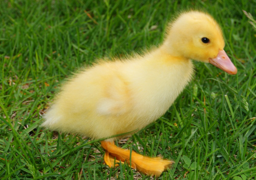

This is a: duck.
Probability of class chicken: 0.0000

Probability of class duck: 1.0000

Probability of class swan: 0.0000

Probability of class turkey: 0.0000



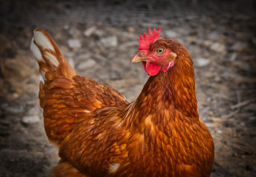

This is a: chicken.
Probability of class chicken: 1.0000

Probability of class duck: 0.0000

Probability of class swan: 0.0000

Probability of class turkey: 0.0000



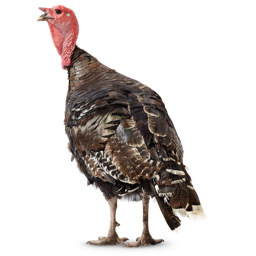

This is a: turkey.
Probability of class chicken: 0.0009

Probability of class duck: 0.0000

Probability of class swan: 0.0013

Probability of class turkey: 0.9978



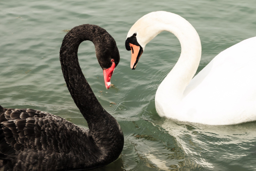

This is a: swan.
Probability of class chicken: 0.0000

Probability of class duck: 0.0000

Probability of class swan: 1.0000

Probability of class turkey: 0.0000



In [9]:
for classes in searches:
    prediction, _ , probs = learn.predict(PILImage.create(f'{classes}.jpg'))
    display(Image.open(f'{classes}.jpg').to_thumb(256,256))
    print(f"This is a: {prediction}.")
    for i, prob in enumerate(probs.tolist()):
        print(f"Probability of class {learn.dls.vocab[i]}: {prob:.4f}\n")

# Reference
- https://course.fast.ai/Resources/book.html
- https://github.com/fastai/fastbook/blob/master/01_intro.ipynb
- https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-dataLinks
- https://www.youtube.com/watch?v=8SF_h3xF3cE